<a href="https://colab.research.google.com/github/shreytanwar/Deep-Belief-Network-For-Software-Fault-Prediction-II/blob/main/JustInTime_SW_Pred_Ensemble_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import tensorflow as tf
import sklearn.metrics
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##Preprocessing

In [3]:
bugzilla = pd.read_csv('/content/drive/My Drive/dataset/bugzilla.csv')
columba = pd.read_csv('/content/drive/My Drive/dataset/columba.csv')
jdt = pd.read_csv('/content/drive/My Drive/dataset/jdt.csv')
mozilla = pd.read_csv('/content/drive/My Drive/dataset/mozilla.csv')
platform = pd.read_csv('/content/drive/My Drive/dataset/platform.csv')
postgres = pd.read_csv('/content/drive/My Drive/dataset/postgres.csv')

df = pd.read_csv('/content/drive/My Drive/dataset/FinalDF.csv')

# df = pd.concat([bugzilla, columba, jdt, mozilla, platform, postgres]) 
# df = df.reset_index(drop=True)

In [4]:
def normalize(x):
  x = x.astype(float)
  min = np.min(x)
  max = np.max(x)
  return (x - min)/(max-min)

In [5]:
def view_values(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([-1,1])
    print(image)

In [6]:
print("Shape of dataframe: ", df.shape)  

Shape of dataframe:  (62737, 15)


In [7]:
# Droping unnecessary String columns
df = df.drop(['commitdate','transactionid'], axis=1)

KeyError: ignored

In [8]:
df.head()

,ns,nm,nf,entropy,la,ld,lt,fix,ndev,pd,npt,exp,rexp,sexp,bug
0,1,1,1,0.000000,0.213115,2.622951,61.000000,1,3,74,1.000000,654,452.000000,651,0
1,1,1,4,0.000000,0.000000,0.000000,315.750000,1,1,0,0.250000,5446,2027.481746,202,1
2,1,1,3,0.905713,0.079585,0.013841,96.333333,1,3,46,1.000000,1217,1154.500000,136,0
3,1,1,1,0.000000,0.090909,0.079545,88.000000,0,3,5,1.000000,16736,5511.066667,16736,0
4,1,3,12,0.731805,1.880000,0.578947,39.583333,0,4,653,0.583333,265,265.000000,69,1


In [9]:
# count1 = np.count_nonzero(df.bug, axis=0)
# count1

In [10]:
# #More Balanced DataFrame
# deleted = 0
# for i in range(df.shape[0]-1, 0, -1 ):
#   if deleted == 164680:
#     break
#   elif df.iloc[i].bug == 0:
#     df = df.drop(df.index[i])
#     if(count1 > np.count_nonzero(df.bug, axis=0)):
#       print('kata')
#       break
#     deleted = deleted + 1
#     if deleted % 1716 == 0:
#       print('Completed: ',deleted / 1716, ' %');

In [11]:
df = df.sample(frac = 1) 

Save the DataFrame

In [12]:
# df.to_csv(r'/content/drive/My Drive/dataset/FinalDF.csv', index = False)

In [13]:
#Splitting Attributes and Labels
train_X = df.iloc[:,:-1].apply(func=normalize, axis=0)
train_Y = df.iloc[:,-1]

In [14]:
# df=df.drop(['transactionid'], axis=1)
print(df.head())

       ns  nm  nf   entropy        la  ...       npt    exp         rexp   sexp  bug
40102   1  13  18  0.766777  0.093023  ...  0.666667   5061  4231.500000   5029    1
25020   1   1   1  0.000000  0.009740  ...  1.000000  12527  4497.613997   2805    1
18760   1   1   1  0.000000  0.002513  ...  1.000000   1067  1067.000000   1041    0
29596   1   1   1  0.000000  0.002545  ...  1.000000  10949  2545.469986  10563    0
61646   1   1   1  0.000000  0.107692  ...  1.000000    441   400.000000    440    0

[5 rows x 15 columns]


#**DBN**

In [15]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)
    # forward pass, where h is the hidden layer and v is the visible layer
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)
    # backward pass
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    # sampling function
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        #To update the weights, we perform constrastive divergence.
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        # We also define the error as the MSE
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X),  self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch,  _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list
    #function to generate new features from the generative model that the RBM has learned
    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

In [16]:
inputX = df.iloc[:,:-1].apply(func=normalize, axis=0).values
inputY= df.iloc[:,-1].values
print(type(inputX))
inputX = inputX.astype(np.float32)

#List to hold RBMs
rbm_list = []

#define parameters of RBMs we will train
# 14-20-12-12-2

# def __init__(self, input_size, output_size,learning_rate, epochs, batchsize):
rbm_list.append(RBM(14, 20, 0.1, 200, 100))
rbm_list.append(RBM(20, 12, 0.025, 50, 100))
rbm_list.append(RBM(12, 12, 0.025, 50, 100))

<class 'numpy.ndarray'>


In [17]:
inputX.shape

(62737, 14)

In [18]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [19]:
outputList = []
error_list = []

#For each RBM in out list
for i in range(0, len(rbm_list)):
    print('RBM', i+1)
    #Train new RBM
    rbm = rbm_list[i]
    err = rbm.train(inputX)
    error_list.append(err)

    #Return output layer
    #sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)
    outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)
    outputList.append(outputX)
    inputX= hiddenX

RBM 1
Instructions for updating:
Use `tf.cast` instead.
Epoch: 0 reconstruction error: 0.105670
Epoch: 1 reconstruction error: 0.106234
Epoch: 2 reconstruction error: 0.106754
Epoch: 3 reconstruction error: 0.107348
Epoch: 4 reconstruction error: 0.105176
Epoch: 5 reconstruction error: 0.105729
Epoch: 6 reconstruction error: 0.104871
Epoch: 7 reconstruction error: 0.103896
Epoch: 8 reconstruction error: 0.103429
Epoch: 9 reconstruction error: 0.100656
Epoch: 10 reconstruction error: 0.100244
Epoch: 11 reconstruction error: 0.101483
Epoch: 12 reconstruction error: 0.100236
Epoch: 13 reconstruction error: 0.098903
Epoch: 14 reconstruction error: 0.099635
Epoch: 15 reconstruction error: 0.097501
Epoch: 16 reconstruction error: 0.095406
Epoch: 17 reconstruction error: 0.094907
Epoch: 18 reconstruction error: 0.096011
Epoch: 19 reconstruction error: 0.093111
Epoch: 20 reconstruction error: 0.092634
Epoch: 21 reconstruction error: 0.095316
Epoch: 22 reconstruction error: 0.093990
Epoch: 23 r

RBM 1


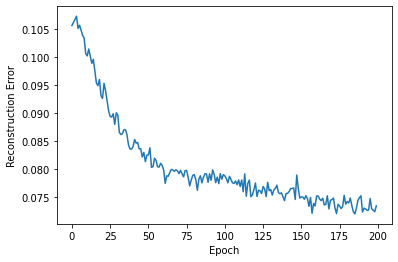

RBM 2


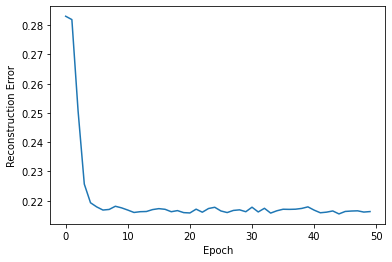

RBM 3


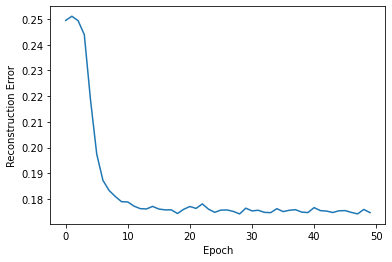

In [20]:
i = 1
for err in error_list:
    print("RBM",i)
    pd.Series(err).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction Error")
    plt.show()
    i += 1

In [21]:
outputX.shape

(62737, 12)

##**Classifier**


Used outputX as the Input for the Classifer

In [55]:
numrows = len(train_Y)
split = (int)(0.8 * numrows)

In [23]:
Y_Train = train_Y.iloc[:split].values
Y_Train.shape

Y_Test = train_Y.iloc[split + 1:].values
Y_Test.shape

(12547,)

In [24]:
X_New_Train = outputX
X_New_Train = X_New_Train[:split, :]
Y_Train = Y_Train.reshape((-1,1))

In [25]:
X_Test = outputX
X_Test = X_Test[split + 1:, :]

ANN

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
ann = Sequential()

ann.add(Dense (6, activation = 'relu', input_dim = 12))

ann.add(Dense (6, activation = 'relu'))

ann.add(Dense(1, activation = 'sigmoid'))

ann.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

ann.fit(X_New_Train, Y_Train, batch_size = 200, epochs = 100)

##Ensemble
* LogisticRegression
* GaussianNB
* RandomForestClassifier

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [35]:
row_Y = Y_Train.reshape(Y_Train.shape[0],)

In [36]:
lr = LogisticRegression(random_state=1)
lr.fit(X_New_Train, row_Y)

forest = RandomForestClassifier(n_estimators=50, random_state=1)
forest.fit(X_New_Train, row_Y)

gnb = GaussianNB()
gnb.fit(X_New_Train, row_Y)

GaussianNB(priors=None, var_smoothing=1e-09)

###F1 Score

In [37]:
def f1score( tn, fp, fn, tp):
  precision = tp/(tp + fp)
  print('Precision: ',precision)
  recall = tp/(tp+fn)
  print('Recall: ',recall)
  return 2 * (precision * recall) / (precision + recall)

In [56]:
y_preds = lr.predict(outputX)
y_preds = (y_preds > 0.5)
y_preds_final = np.array(y_preds)
tn, fp, fn, tp = confusion_matrix(train_Y, y_preds, labels=[0,1]).ravel()
print('F1-score: ',f1score(tn, fp, fn, tp))

Precision:  0.570131950270765
Recall:  0.536496088423168
F1-score:  0.5528028398165951


##Seprate Dataframes

In [44]:
bugzilla = pd.read_csv('/content/drive/My Drive/dataset/bugzilla.csv')
columba = pd.read_csv('/content/drive/My Drive/dataset/columba.csv')
jdt = pd.read_csv('/content/drive/My Drive/dataset/jdt.csv')
mozilla = pd.read_csv('/content/drive/My Drive/dataset/mozilla.csv')
platform = pd.read_csv('/content/drive/My Drive/dataset/platform.csv')
postgres = pd.read_csv('/content/drive/My Drive/dataset/postgres.csv')

In [45]:
def preds(mod, op):
  y_preds = mod.predict(op)
  y_preds = (y_preds > 0.5)*1
  y_preds_final = np.array(y_preds)
  return y_preds_final

In [46]:
def concatenate(list1, list2, list3, list4):
  l = np.zeros(len(list1))
  for i in range (0, len(list1)-1):
    l[i] = (list1[i] + list2[i] + list3[i] + list4[i]) / 4
  return l

In [47]:
def predict(op):
  y_predict = concatenate(preds(ann, op), preds(lr, op), preds(forest, op), preds(gnb, op))
  y_predict = (y_predict > 0.5)
  return y_predict

In [48]:
def dbn_op(inputX):
  for i in range(0, len(rbm_list)):
      rbm = rbm_list[i]

      outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)
      inputX= hiddenX
  
  return outputX

In [49]:
def dataframe_score(df1):
  df1 = df1.drop(['commitdate','transactionid'], axis=1)
  train_X_op = df1.iloc[:,:-1].apply(func=normalize, axis=0).astype(np.float32)
  train_Y_op = df1.iloc[:,-1]

  op = dbn_op(train_X_op)

  y_pred_op = predict(op)

  cm = confusion_matrix(train_Y_op, y_pred_op)
  print(cm) 

  tn, fp, fn, tp = confusion_matrix(train_Y_op, y_pred_op, labels=[0,1]).ravel()
  print('F1-score: ',f1score(tn, fp, fn, tp))

In [57]:
print('bugzilla:')
dataframe_score(bugzilla)
print('--------------------------------------------------------------------')
print('columba:')
dataframe_score(columba)
print('--------------------------------------------------------------------')
print('jdt:')
dataframe_score(jdt)
print('--------------------------------------------------------------------')
print('mozilla:')
dataframe_score(mozilla)
print('--------------------------------------------------------------------')
print('platform:')
dataframe_score(platform)
print('--------------------------------------------------------------------')
print('postgres:')
dataframe_score(postgres)
print('--------------------------------------------------------------------')
print('Overall:')
cm = confusion_matrix(train_Y, y_preds)
print(cm)
tn, fp, fn, tp = confusion_matrix(train_Y, y_preds, labels=[0,1]).ravel()
print('F1-score: ',f1score(tn, fp, fn, tp))

bugzilla:
[[ 816 2108]
 [ 316 1380]]
Precision:  0.3956422018348624
Recall:  0.8136792452830188
F1-score:  0.5324074074074074
--------------------------------------------------------------------
columba:
[[2162  932]
 [ 964  397]]
Precision:  0.2987208427389014
Recall:  0.2916972814107274
F1-score:  0.2951672862453531
--------------------------------------------------------------------
jdt:
[[22427  7870]
 [ 3096  1993]]
Precision:  0.20206833620602252
Recall:  0.3916290037335429
F1-score:  0.26658640984483684
--------------------------------------------------------------------
mozilla:
[[41192 51934]
 [ 1701  3448]]
Precision:  0.06225849554006717
Recall:  0.6696445911827539
F1-score:  0.11392509623168294
--------------------------------------------------------------------
platform:
[[36775 18023]
 [ 4322  5130]]
Precision:  0.22156955902042932
Recall:  0.5427422767668219
F1-score:  0.3146756632418341
--------------------------------------------------------------------
postgres:
[[926

ValueError: ignored

In [58]:
tn, fp, fn, tp = confusion_matrix(train_Y, y_preds, labels=[0,1]).ravel()
print('F1-score: ',f1score(tn, fp, fn, tp))

Precision:  0.570131950270765
Recall:  0.536496088423168
F1-score:  0.5528028398165951
